This takes a simple neural network and applies it to the given problem. The only semi-involved part is that the losses are weighted so the background is less considered

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Imports
import tensorflow as tf
import numpy as np
from arc_code.data import get_data
import math
import matplotlib.pyplot as plt
#import cv2
from PIL import Image

In [7]:
# getting the data
X_train, Y_train, X_test, Y_test = get_data('../data', training_set = True, grouped_by_problem = False)

In [8]:
def pad(grid, shape_to_pad_to, fill = -1):
    # pads the grid to be of shape <shape_to_pad_to> with
    # fill values <fill>
    x_resize, y_resize = (shape_to_pad_to - grid.shape )/2.0
    
    def transform_format(arr):
        if arr%1 != 0:
            arr = [math.floor(arr),math.ceil(arr)]
        else:
            arr = [int(arr), int(arr)]
        return arr
    
    x_resize, y_resize = transform_format(x_resize), transform_format(y_resize)
    padded = np.pad(grid,[x_resize,y_resize,], 'constant', constant_values=fill)
    # add last layer
    return padded

In [9]:
def process_data(data, resize_shape, resize_method = 'pad', fill = 10):
    new_data = np.zeros((len(data),resize_shape[0], resize_shape[1], 1), dtype = np.float32)
    for i,x in enumerate(data):
        if resize_method == 'pad':
            x = pad(x, resize_shape, fill = fill)
        else:
            x = np.array(Image.fromarray(x.astype(np.uint8)).resize((30,30),0))
        new_data[i] = (x[:,:,np.newaxis]).astype(np.float32)
  
    return new_data

In [10]:
def one_layer_flat_model(num_classes, flattened_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=np.append(flattened_shape,1)),
        #keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])
    return model

In [11]:
def one_layer(input_shape, num_classes = 11, filters = 3, kernel_size = 3,
              stride = 1, kernel_regularizer = None,
             activity_regularizer = None, bias_regularizer = None, dilation = 1):
    # assume input shape == outputshape
    #upsample_kernel_size = output_shape - ((input_shape - 1) * stride
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            filters = filters,
            kernel_size = kernel_size,
            strides= stride,
            padding="valid",
            activation='relu',
            kernel_regularizer = kernel_regularizer,
            activity_regularizer = activity_regularizer,
            bias_regularizer = bias_regularizer,
            input_shape=np.append(input_shape,1)),
        tf.keras.layers.Conv2DTranspose(
            filters = num_classes,
            kernel_size = kernel_size,
            strides= stride,
            padding="valid",
            output_padding=None,
            data_format=None,
            dilation_rate=dilation,
            activation="relu",
            use_bias=True,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer)
    ])
    return model

In [24]:
labels = tf.constant(np.random.randint(0, 5, 6), dtype=tf.int32)

# specify some class weightings
class_weights = tf.constant([0.3, 0.1, 0.2, 0.3, 0.1])

# specify the weights for each sample in the batch (without having to compute the onehot label matrix)
weights = tf.gather(class_weights, labels)

In [26]:
labels.numpy()

array([1, 1, 0, 3, 1, 0], dtype=int32)

In [27]:
weights.numpy()

array([0.1, 0.1, 0.3, 0.3, 0.1, 0.3], dtype=float32)

In [66]:
def weighted_loss(y_true, y_pred):
    # your class weights
    class_weights = tf.convert_to_tensor(np.append(np.repeat(1.0, 10),0.1), dtype = y_true.dtype)
    # deduce weights for batch samples based on their true label
    weights = tf.reduce_sum(class_weights * y_true, axis=1)
    # compute your (unweighted) softmax cross entropy loss
    unweighted_losses = tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred)
    # apply the weights, relying on broadcasting of the multiplication
    print(class_weights.shape, y_true.shape, y_pred.shape, weights.shape,unweighted_losses.shape)
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)

In [84]:
def weighted_loss(y_true, y_pred):
        w = tf.reduce_sum(y_true)/tf.cast(tf.size(y_true), tf.float32)
        loss = w * tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred)
        return loss
    

In [85]:
def run(model_func, X_train, Y_train, X_test, Y_test, num_epochs = 50,
         resize_shape = np.array((30,30)), resize_method = 'pad', fill = 10, *args):
    
    X_train = process_data(X_train, resize_shape = resize_shape, resize_method = resize_method, fill = fill)
    Y_train = process_data(Y_train, resize_shape = resize_shape, resize_method = resize_method, fill = fill)
    X_test = process_data(X_test, resize_shape = resize_shape, resize_method = resize_method, fill = fill)
    Y_test = process_data(Y_test, resize_shape = resize_shape, resize_method = resize_method, fill = fill)
    
    model = model_func(input_shape = resize_shape, *args)
    model.compile(optimizer='adam',
              loss=weighted_loss,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    model.fit(X_train, Y_train, epochs=num_epochs, validation_data = (X_test, Y_test))
    test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
    return model, X_test, Y_test

In [86]:
model, X_test_proc, Y_test_proc = run(one_layer, X_train, Y_train, X_test, Y_test, num_epochs = 10, resize_method = 'resize')

Train on 1301 samples, validate on 416 samples
Epoch 1/10
1301/1301 [==============================] - 4s 3ms/sample - loss: 145.1384 - accuracy: 0.0347 - val_loss: 167.7167 - val_accuracy: 0.0416
Epoch 2/10
1301/1301 [==============================] - 3s 2ms/sample - loss: 176.0631 - accuracy: 0.1048 - val_loss: 192.7043 - val_accuracy: 0.1130
Epoch 3/10
1301/1301 [==============================] - 3s 2ms/sample - loss: 197.5781 - accuracy: 0.1721 - val_loss: 221.1086 - val_accuracy: 0.4206
Epoch 4/10
1301/1301 [==============================] - 3s 2ms/sample - loss: 239.6323 - accuracy: 0.4879 - val_loss: 279.7017 - val_accuracy: 0.5038
Epoch 5/10
1301/1301 [==============================] - 4s 3ms/sample - loss: 305.4075 - accuracy: 0.5336 - val_loss: 346.9369 - val_accuracy: 0.5349
Epoch 6/10
1301/1301 [==============================] - 4s 3ms/sample - loss: 368.0255 - accuracy: 0.5512 - val_loss: 413.9532 - val_accuracy: 0.5453
Epoch 7/10
1301/1301 [==============================]

Display the problem with the best accuracy

In [101]:
best_acc = 0
which_best = -1
for i,x in enumerate(X_test_proc):
    test_loss, test_acc = model.evaluate(X_test_proc[i:i+1],  Y_test_proc[i:i+1], verbose=0)
    if test_acc > best_acc:
        best_acc = test_acc
        which_best = i

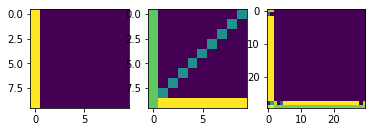

In [102]:
_, ax = plt.subplots(1,3)
ax[0].imshow(X_test[which_best])
ax[1].imshow(Y_test[which_best])
ax[2].imshow(np.argmax(model(X_test_proc[which_best:which_best+1]).numpy(), axis = 3)[0])